In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchattacks
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Напишем сеть LeNet для нашей задачи

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 канал на вход (ч/б изображение), 6 выходов и ядро 5х5
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 каналов вход, 16 выходов и ядро 5х5
        self.fc1 = nn.Linear(16*4*4, 120) # выравниваем в тензор (16х4х4 = 256), 120 признаков 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #Применяем первый сверточный слой, затем функцию активации ReLU.
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) #Применяем операцию максимального пулинга с окном 2x2 к результату первого сверточного слоя.
        x = x.view(-1, self.num_flat_features(x)) #Преобразуем данные из матрицы в вектор (плоскость) для подачи в полносвязные слои
        x = F.relu(self.fc1(x)) #Применяем первый полносвязный слой с функцией активации ReLU.
        x = F.relu(self.fc2(x)) #Применяем второй полносвязный слой с функцией активации ReLU.
        x = self.fc3(x) #Применяем третий полносвязный слой без функции активации ReLU, так как это выходной слой
        return x

    def num_flat_features(self, x): # метод используется для вычисления количества признаков после сверточных и пулинговых слоев перед подачей в первый полносвязный слой.

                                    # береv размер каждого измерения входного тензора (кроме первого, который является размером пакета) и умножает их, чтобы получить общее количество признаков.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Подготовим изображение, датасет и лоадер

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 9969627.92it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6050574.53it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
num_epochs = 10

Обучим модель

Epoch 1/10, Loss: 0.2400
Epoch 2/10, Loss: 0.0700
Epoch 3/10, Loss: 0.0511
Epoch 4/10, Loss: 0.0399
Epoch 5/10, Loss: 0.0337
Epoch 6/10, Loss: 0.0281
Epoch 7/10, Loss: 0.0245
Epoch 8/10, Loss: 0.0200
Epoch 9/10, Loss: 0.0199
Epoch 10/10, Loss: 0.0161


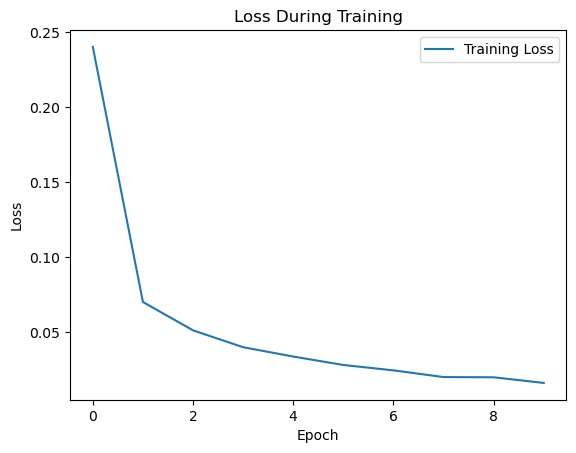

In [8]:
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net = net.to(device)
net.train()
epoch_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    

plt.plot(epoch_losses, label='Training Loss')
plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()  

In [15]:
def imshow(img):
    # Возвращаем изображение к его исходному диапазону
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #[C,H,W] -> [H,W,C]
    plt.axis('off')

Проведем адверсиальную атаку

In [28]:
# Выбираем изображение для атаки
images, labels = next(iter(trainloader))
image, label = images[0], labels[0]

# Инициализируем атаку
attack = torchattacks.FGSM(net, eps=1)

# Применяем атаку
adversarial_image = attack(image.unsqueeze(0), label.unsqueeze(0))

# Проверяем результат
output = net(adversarial_image)
predicted = torch.max(output.data, 1)[1]

Построим оригинальное изображение

Text(0.5, 1.0, 'Original Image - Class: 0')

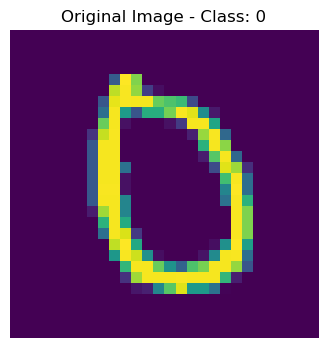

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
imshow(image)
plt.title(f'Original Image - Class: {label.item()}')

Построим адверсиальное изображение

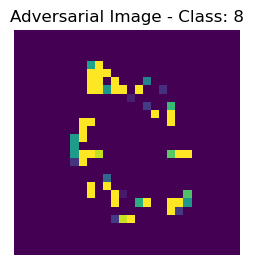

In [30]:
plt.subplot(1, 2, 2)
adversarial = adversarial_image.squeeze(0).cpu().detach()
imshow(adversarial)
plt.title(f'Adversarial Image - Class: {predicted.item()}')

plt.show()

Как мы видим, атака удалась и модель думает что это 8

Найдем разницу между адверсиальным изображением и оригиналом

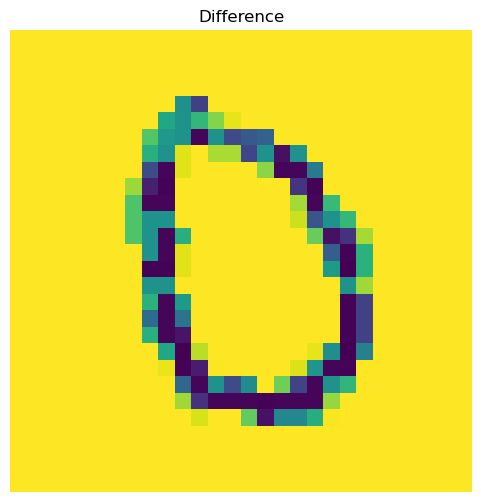

In [31]:
difference = adversarial_image.squeeze(0).cpu().detach() - image

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
imshow(difference)
plt.title('Difference')
plt.show()